# Netflix data Analysis

Прошел вводный курс от Яндекса и решил попрактиковаться и сделать мини-проект на реальных данных. В качестве этих самых "реальных данных" буду использовать "Netflix Movies and TV Shows" dataset взятый из топа kaggle.com

Первой гипотезой моего исследования ставлю следующее предположение:
* Is Netflix has increasingly focusing on TV rather than movies in recent years?
    
Считаю, что эту гипотезу вполне можно подтвердить количественными методами анализа, которыми я уже способен оперировать.
Главная задача на данный момент, определить метрику по которой можно будет оценивать именно фокус самого нетфликса на тот или иной сегмент. Ну а пока разберусь с импортом пандаса из Jupiter'a

In [97]:
import pandas as pd

Ну а теперь можно и посмотреть наши данные

## Предобработка данных

In [98]:
df = pd.read_csv('./netflix_titles.csv')

In [188]:
df.loc[:2]

,show_id,type,title,director,actors,countries,date_added_to_netflix,release_year,rating,duration,genres,description,yr_added,month_added,day_added
0,s1,TV Show,3%,unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,14
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,23
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,20


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [102]:
df.duplicated().sum()

0

Переименую столбцы в более интуитивно понятные (мне) имена

In [103]:
cols = list(df.columns)
cols[4] = 'actors'
cols[5] = 'countries'
cols[6] = 'date_added_to_netflix'
cols[10] = 'genres'
df.set_axis(cols, axis='columns', inplace=True)

Дупликатов нет, круто. Но есть много пропущенных значений. Пора определиться, какие данные нам понадобятся для анализа.

     0   show_id       +
     1   type          ++
     2   title         +
     3   director      -
     4   actors          ?
     5   countries       ?
     6   date_added_to_netflix    +
     7   release_year  +
     8   rating        ++
     9   duration      ?
     10  genres        +
     11  description   -
где ++: ключевой параметр
    +: нужный параметр
    ?: может понадобится
    -: не нужен

Чтобы нормально использовать столбец genres, хранящий в себе жанры, с ним стоит поработать отдельно. Есть проблемы:
* названия одних и тех же жанров различаются у сериалов и фильмов, что не позволит сделать выборку одного и того же жанра удобно, но может и можно жить
* разобраться как использовать столбец с множеством значений через запятую

Сделаем это если все таки понадобится, а пока доведем преобработку до конца. Начнем с работой с пустыми значениями
Столбцы director, cast, country не выглядят ключевыми поэтому им просто заполняю пробелы значением 'unknown'. А вот записи где значения из date_added_to_netflix пропущены - удалю, так как это один из ключевых параметров анализа.

In [105]:
df.dropna(subset = ['date_added_to_netflix'], inplace = True)
df = df.fillna('unknown')

Разобьем дату по колонкам, чтобы можно было группировать по году:

In [189]:
from datetime import datetime as dt

df['yr_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.year
df['month_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.month
df['day_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.day
df.drop(columns=['date_added_to_netflix'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7786
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   show_id                7777 non-null   object
 1   type                   7777 non-null   object
 2   title                  7777 non-null   object
 3   director               7777 non-null   object
 4   actors                 7777 non-null   object
 5   countries              7777 non-null   object
 6   date_added_to_netflix  7777 non-null   object
 7   release_year           7777 non-null   int64 
 8   rating                 7777 non-null   object
 9   duration               7777 non-null   object
 10  genres                 7777 non-null   object
 11  description            7777 non-null   object
 12  yr_added               7777 non-null   int64 
 13  month_added            7777 non-null   int64 
 14  day_added              7777 non-null   int64 
dtypes: int64(4), object(1

## Is Netflix has increasingly focusing on TV show rather than movies in recent years?

Посмотрим количество вышедших на нетфликсе премьер фильмов и сериалов за последнее время с разбивкой по годам:

In [172]:
group = df.groupby(by = ['type', 'yr_added', 'month_added']).count()['title']
d = {'TV Shows': group['TV Show'], 'Movies': group['Movie']}
table = pd.DataFrame(data=d).fillna(0)
table['TV Shows/Movies'] = round(table['TV Shows'] / table['Movies'] * 100, 1)
table.tail(300)
# group.head(10)

TV Shows  Movies  TV Shows/Movies
yr_added month_added                                   
2008     1                 0.0     1.0              0.0
         2                 1.0     0.0              inf
2009     5                 0.0     1.0              0.0
         11                0.0     1.0              0.0
2010     11                0.0     1.0              0.0
...                        ...     ...              ...
2020     9                62.0   116.0             53.4
         10               56.0   117.0             47.9
         11               55.0   103.0             53.4
         12               74.0   101.0             73.3
2021     1                29.0    88.0             33.0

[100 rows x 3 columns]

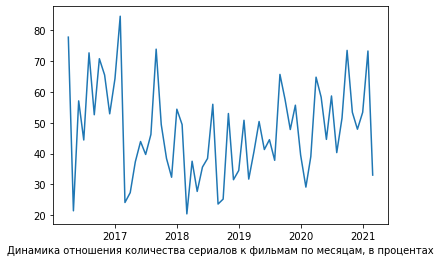

In [182]:
import matplotlib.pyplot as plt
import numpy as np

correlation = table['TV Shows/Movies']

years = 5
indexes = pd.date_range(start=pd.to_datetime('today')-np.timedelta64(years, 'Y'), periods=12*years, freq='M')


plt.plot(indexes, correlation.tail(12*years))
plt.xlabel("Динамика отношения количества сериалов к фильмам по месяцам, в процентах")
plt.show()

### Промежуточные выводы
На графике сложно установить какой либо тенденции. Поэтому, исходя из полученных данных о количестве премьер, нельзя утверждать что сериалов на платформе становится больше, чем фильмов или наоборот.

**Но основываться на этих данных не стоит**, так как реальное положение дел это не описывает. **Одна премьера может собрать огромное количество просмотров, а другая не собрать ничего.**

Более того, можно предположить, что кассовость премьер наоборот толкает скорость выхода новых премьер вниз, так как на их успех расчитывают больше => бюджеты и масштабы увеличиваются => время на сьемку становится больше => меньше премьер в год (высказывание-кандидат на отдельную гипотезу)

Для более качественной проработки нашей основной гипотезы, **нужно достать данные о просмотрах собранных нами картин на нетфликсе.**